# Logistic Regression Notebook

In [1]:
# Non-modeling imports. Specific imports occur below.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size':25})
import numpy as np

In [2]:
# Model related imports below
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
# import zzz

In [3]:
# Import the data. Feel free to change this CSV.

#ZStandardized dataset
df = pd.read_csv("ModelData/msdata.csv")

#Binned dataset
df = pd.read_csv("ModelData/mbdata.csv")

In [4]:
df.shape[0]

1215

In [5]:
from sklearn.model_selection import train_test_split
Train, Test = train_test_split(df,test_size=.2, random_state=1)

Balancing train data

In [6]:
Train['EvergreenFlag'].value_counts()

0.0    799
1.0    173
Name: EvergreenFlag, dtype: int64

In [7]:
from sklearn.utils import resample

In [8]:
positive = Train[Train['EvergreenFlag'] == 1]
negative = Train[Train['EvergreenFlag'] == 0]

positive_up = resample(positive,
                   n_samples=len(negative),
                      random_state=79)
negative_down = resample(negative,
                        n_samples=len(positive),
                        random_state=120)

Train_up = pd.concat([positive_up,negative])
Train_down = pd.concat([positive, negative_down])

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                         save=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
        plt.show()

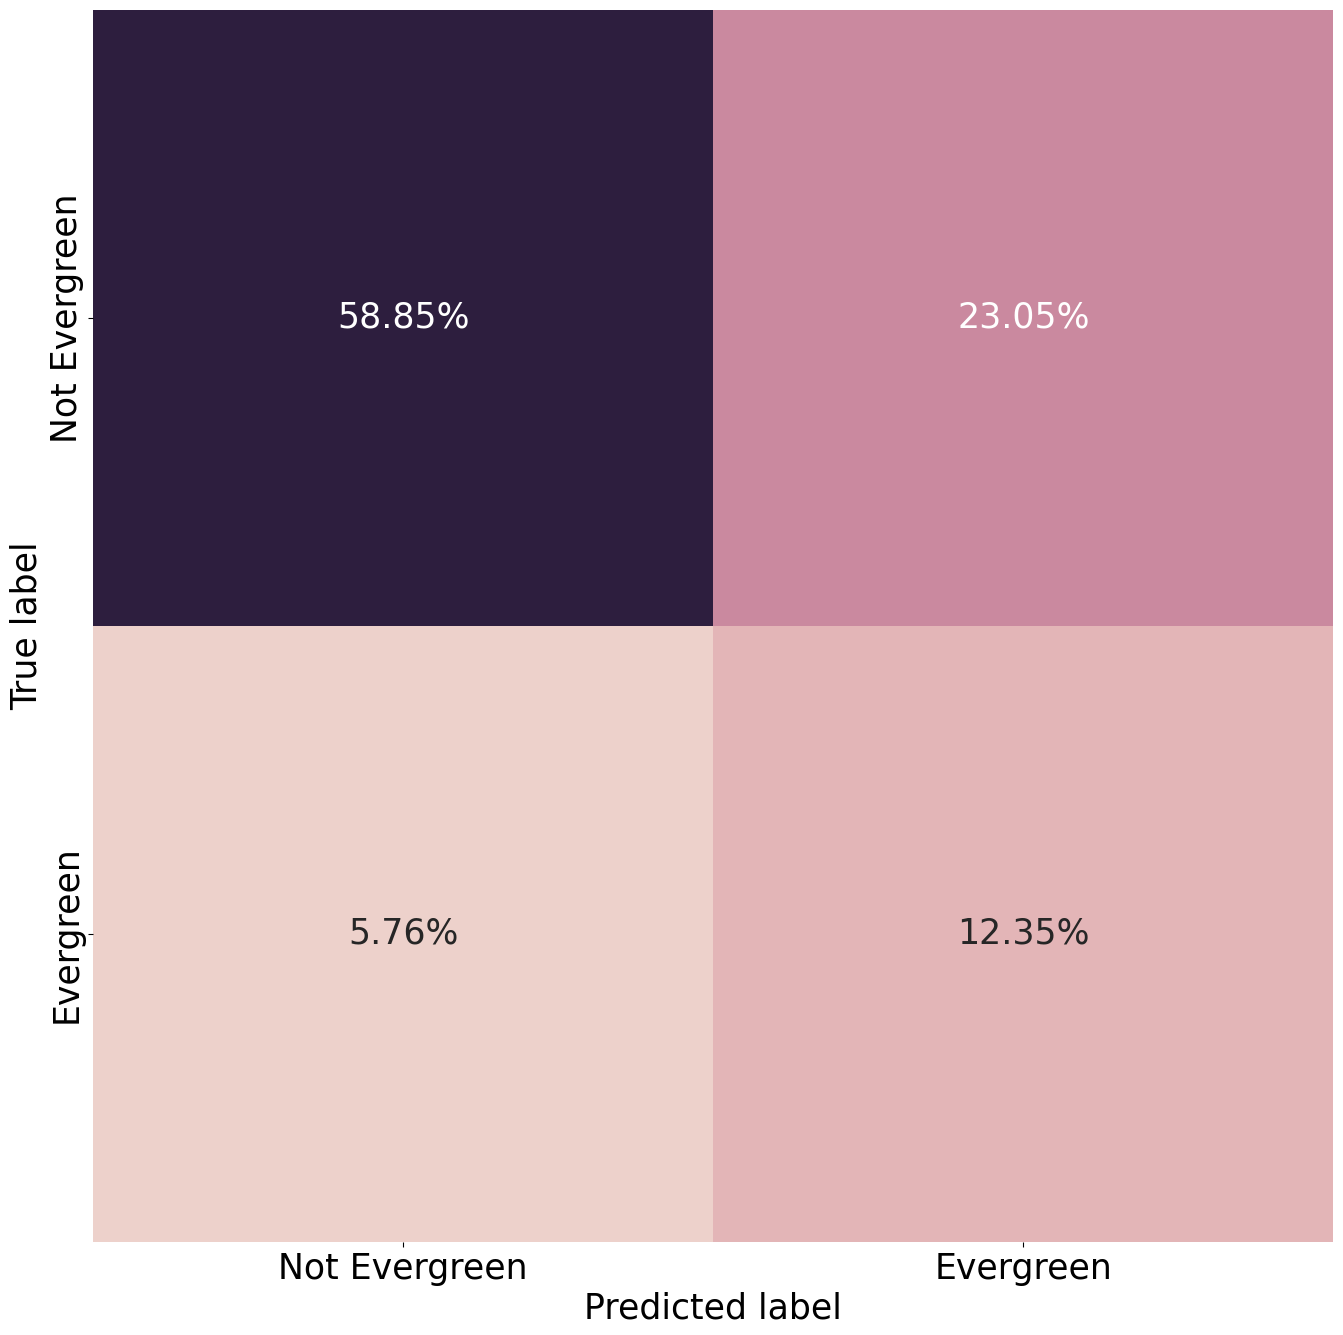

In [10]:
clf = LogisticRegression().fit(Train_up.drop(columns='EvergreenFlag'),Train_up['EvergreenFlag'])
predictions = clf.predict(Test.drop(columns=['EvergreenFlag']))
make_confusion_matrix(confusion_matrix(Test['EvergreenFlag'],predictions),
                     figsize=(16,16),percent=True,count=False,
                     categories=['Not Evergreen','Evergreen'],
                     cbar=False,cmap=sns.cubehelix_palette(as_cmap=True),
                    sum_stats=False,
                     save="Plots/LogisticRegressionHeatmap.png")

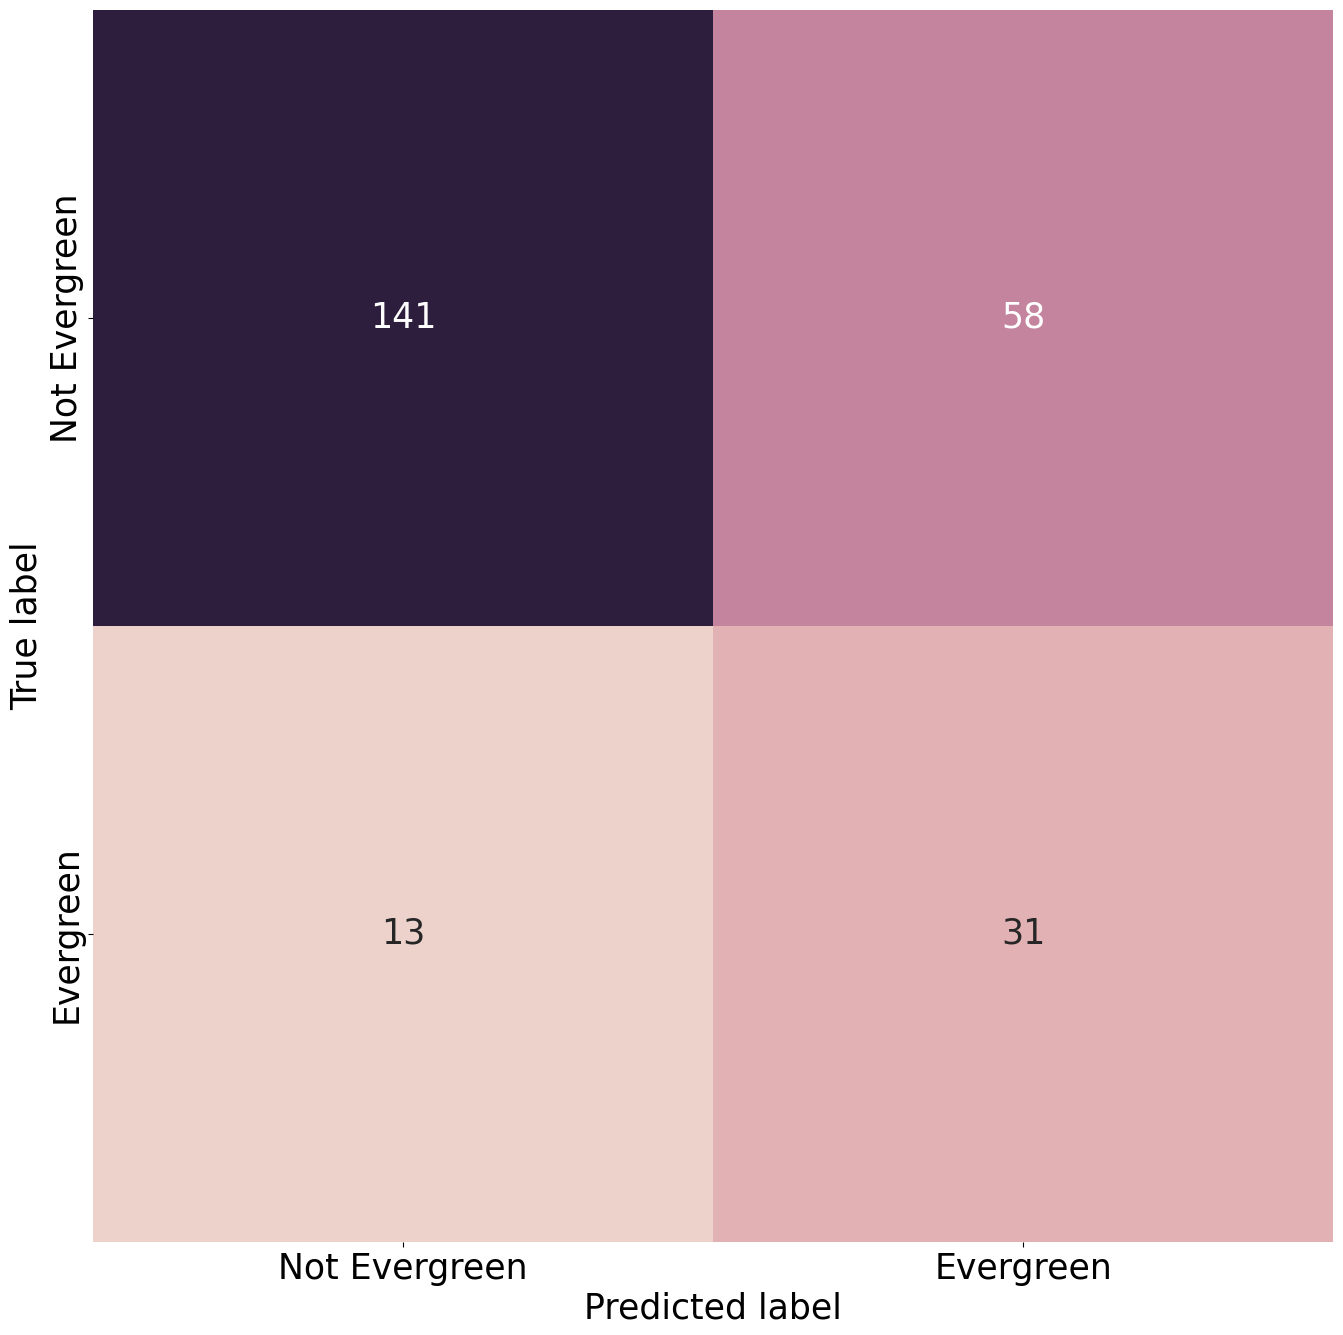

In [11]:
clf = LinearDiscriminantAnalysis().fit(Train_up.drop(columns='EvergreenFlag'),Train_up['EvergreenFlag'])
predictions = clf.predict(Test.drop(columns=['EvergreenFlag']))
make_confusion_matrix(confusion_matrix(Test['EvergreenFlag'],predictions),
                     figsize=(16,16),percent=False,
                     categories=['Not Evergreen','Evergreen'],
                     cbar=False,cmap=sns.cubehelix_palette(as_cmap=True),
                    sum_stats=False,
                     save="Plots/LinearDiscriminantAnalysisHeatmap.png")

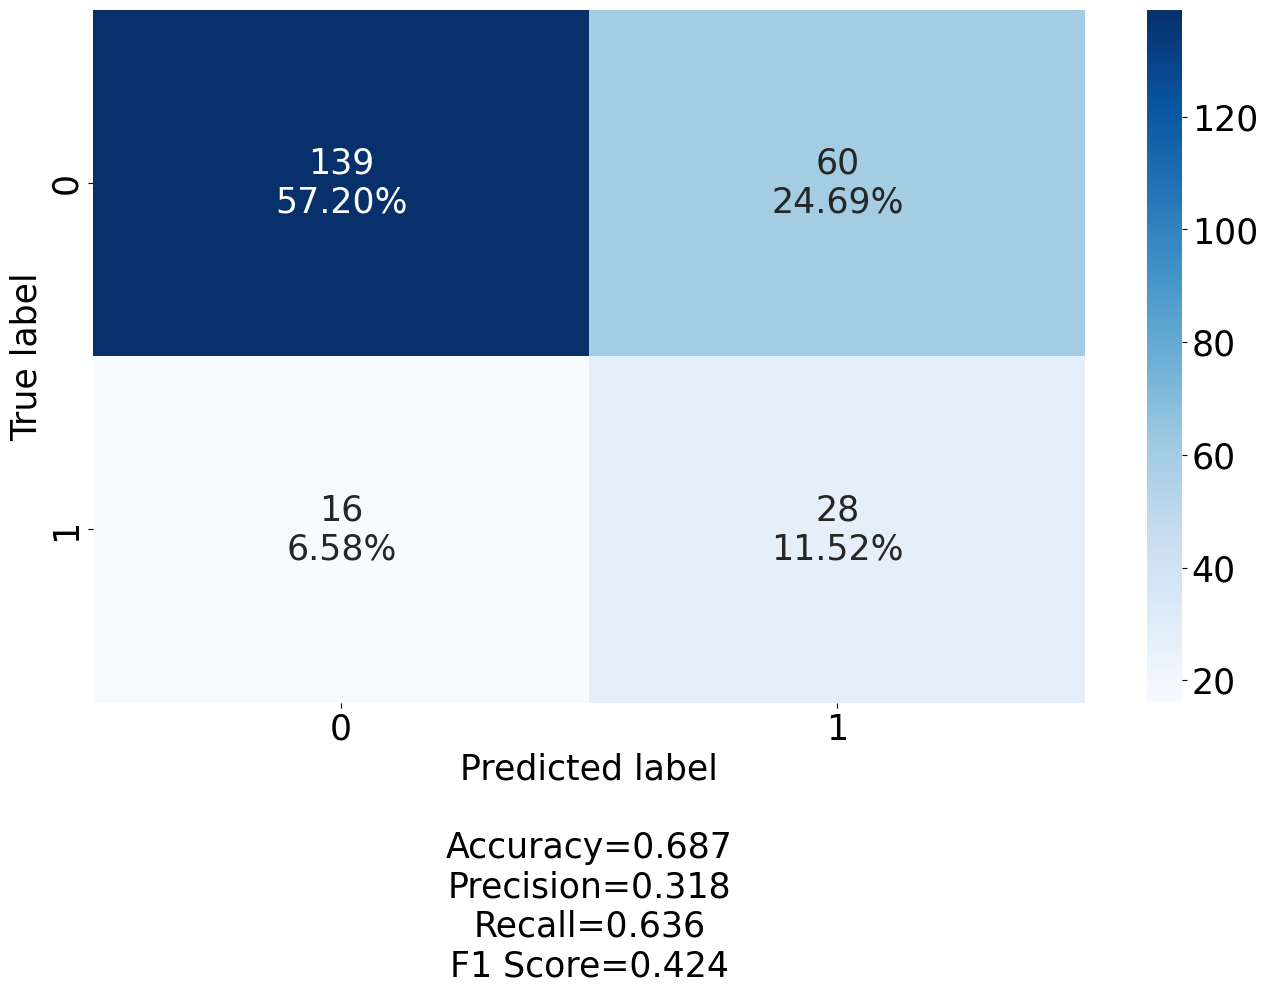

In [12]:
clf = LogisticRegression().fit(Train_down.drop(columns='EvergreenFlag'),Train_down['EvergreenFlag'])
predictions = clf.predict(Test.drop(columns=['EvergreenFlag']))
make_confusion_matrix(confusion_matrix(Test['EvergreenFlag'],predictions),
                     figsize=(16,9))

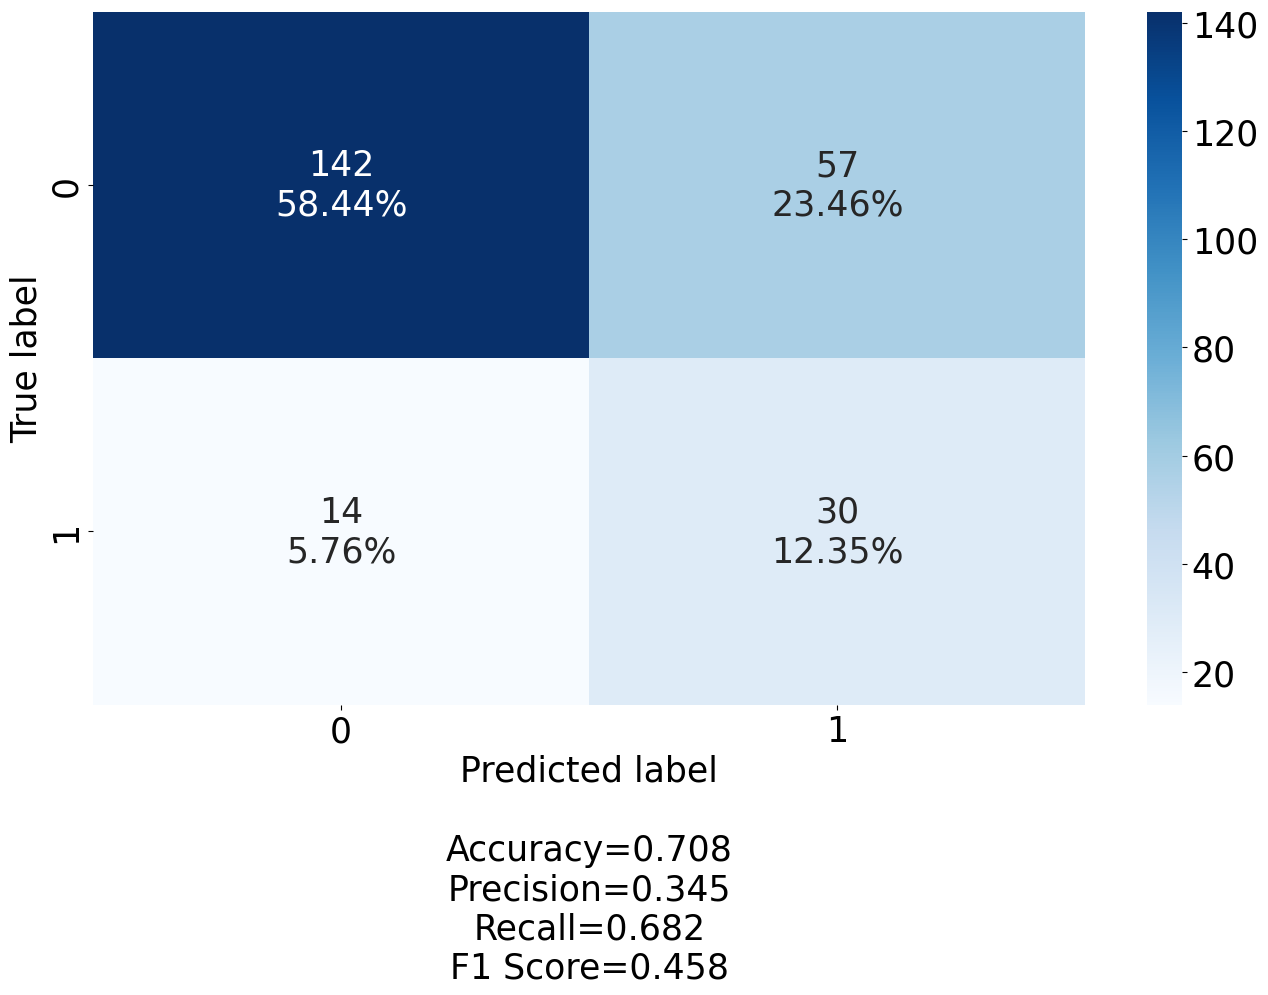

In [13]:
#Good to know there is a balancing parameter in here
clf = LogisticRegression(class_weight='balanced').fit(Train.drop(columns='EvergreenFlag'),Train['EvergreenFlag'])
predictions = clf.predict(Test.drop(columns=['EvergreenFlag']))
make_confusion_matrix(confusion_matrix(Test['EvergreenFlag'],predictions),
                     figsize=(16,9))

In [14]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold


scoring = {
    'Accuracy' : make_scorer(accuracy_score),
    'Recall'   : make_scorer(recall_score)  
}
crossval = KFold(n_splits=4)
clf = LogisticRegression(class_weight='balanced')

results = cross_val_score(estimator=clf,
                         X=df.drop(columns=['EvergreenFlag']),
                         y=df['EvergreenFlag'],
                         cv=crossval,
                         scoring=make_scorer(recall_score))

In [15]:
results.mean()

0.585322080933645

In [16]:
from sklearn.model_selection import train_test_split
Train, Test = train_test_split(df,test_size=.2)

In [17]:
positive = Train[Train['EvergreenFlag'] == 1]
negative = Train[Train['EvergreenFlag'] == 0]

positive_up = resample(positive,
                   n_samples=len(negative),
                      random_state=79)
negative_down = resample(negative,
                        n_samples=len(positive),
                        random_state=120)

Train_up = pd.concat([positive_up,negative])
Train_down = pd.concat([positive, negative_down])

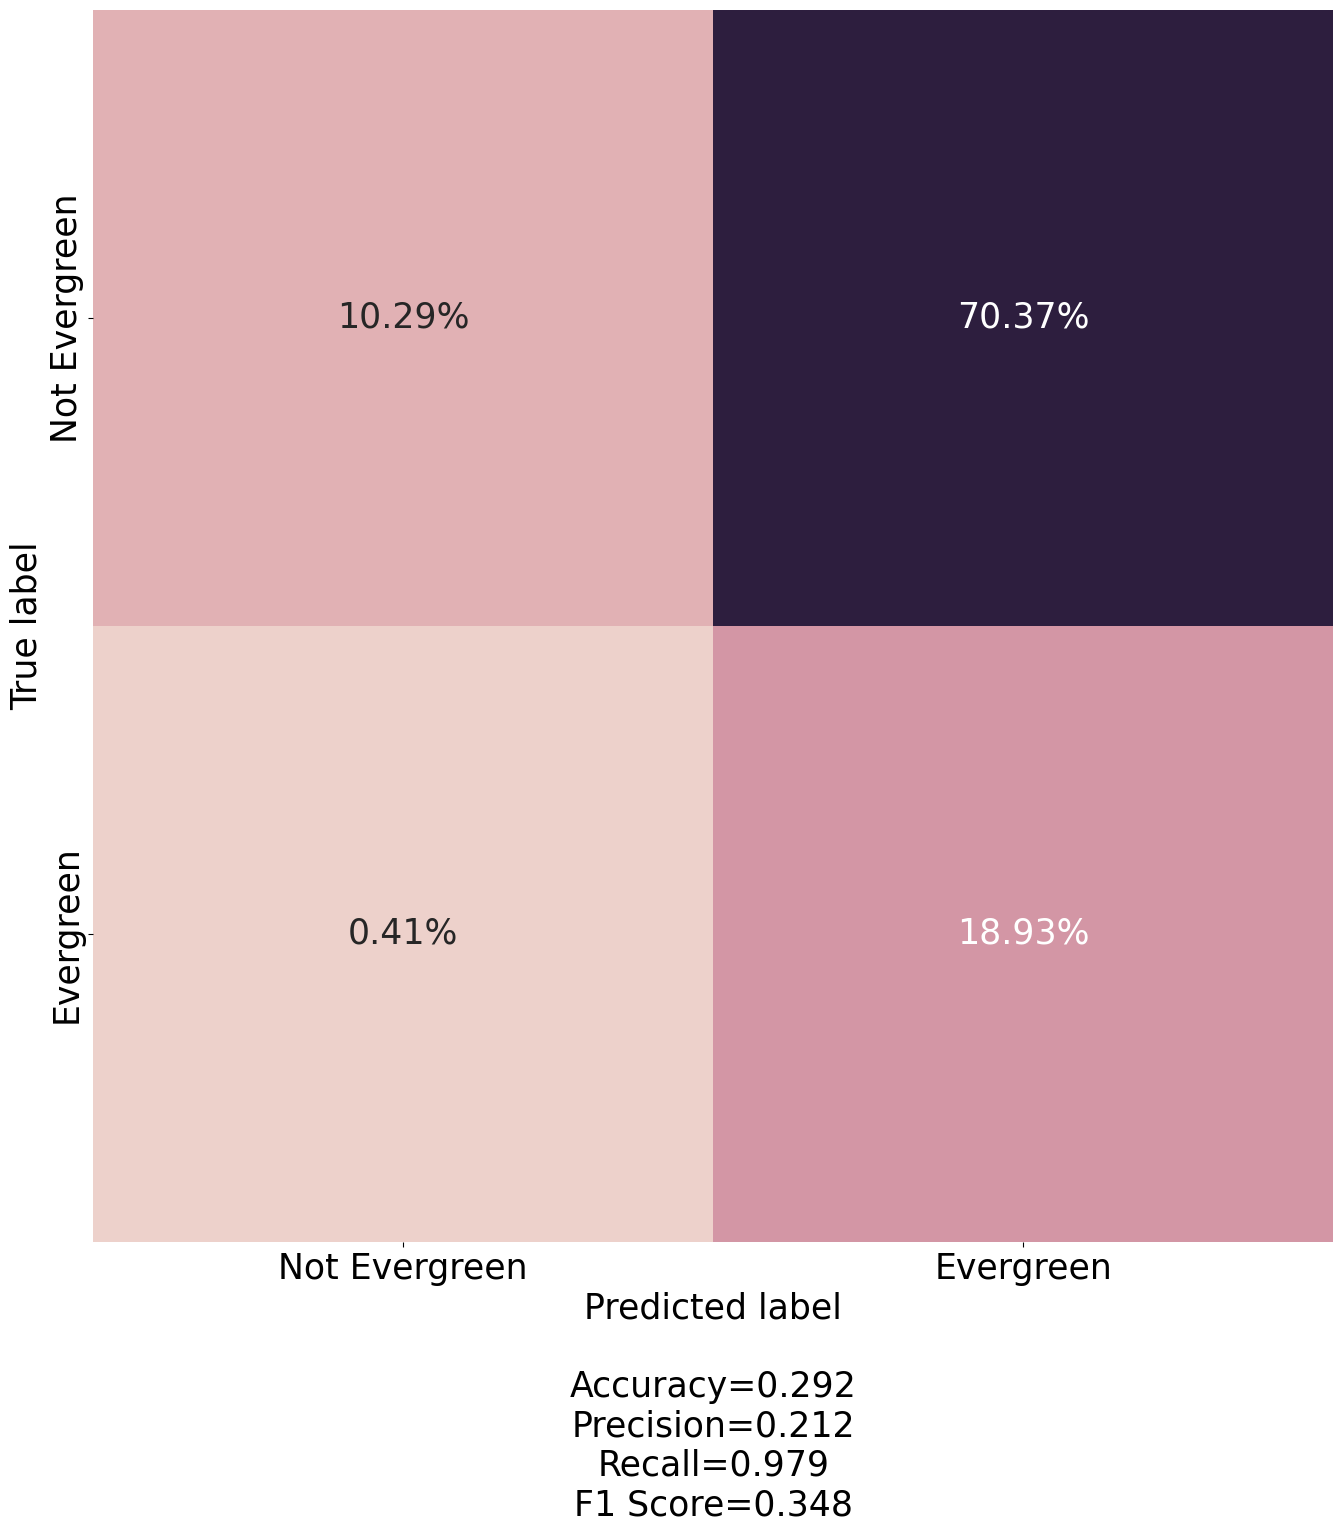

In [18]:
threshold = .2
clf = LogisticRegression().fit(Train_up.drop(columns='EvergreenFlag'),Train_up['EvergreenFlag'])
predictions = pd.DataFrame(clf.predict_proba(Test.drop(columns=['EvergreenFlag'])))
predictions = predictions[1].apply(lambda x: 1 if x>threshold else 0)
make_confusion_matrix(confusion_matrix(Test['EvergreenFlag'],predictions),
                     figsize=(16,16),percent=True,count=False,
                     categories=['Not Evergreen','Evergreen'],
                     cbar=False,cmap=sns.cubehelix_palette(as_cmap=True),
                     save='Plots/ExampleMatrix.png')

## Finding average metrics for models
In order to determine the strength of each model, it is important to get metrics on model performance. The following section runs **100 models** on different random states for train_test_split cross validation and finds the average performance of the models in order to get a better guage of performance. This method was chosen as KFold crossvalidation doesn't offer the choice to change how a prediction is made within a model. The **threshold** for a positive prediction will be chosen by changing the min probability to label a patent as Evergreen. **Logistic Regression** and **Naive Bayes** will be utilized in this section.

### Logit Modeling

In [19]:
precisions = []
accuracies = []
recalls = []
F1s = []
for i in range(100):
    Train, Test = train_test_split(df,test_size=.25)
    positive = Train[Train['EvergreenFlag'] == 1]
    negative = Train[Train['EvergreenFlag'] == 0]

    positive_up = resample(positive,
                   n_samples=len(negative))
    negative_down = resample(negative,
                        n_samples=len(positive))

    Train_up = pd.concat([positive_up,negative])
    threshold = .25
    clf = LogisticRegression().fit(Train_up.drop(columns='EvergreenFlag'),Train_up['EvergreenFlag'])
    predictions = pd.DataFrame(clf.predict_proba(Test.drop(columns=['EvergreenFlag'])))
    predictions = predictions[1].apply(lambda x: 1 if x>threshold else 0)
    cf = confusion_matrix(Test['EvergreenFlag'],predictions)
    
    accuracy  = np.trace(cf) / float(np.sum(cf))
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    F1s.append(f1_score)
    
metricsDF = pd.DataFrame(list(zip(precisions, accuracies, recalls,F1s)),columns=
                        ['Precision','Accuracy','Recall','F1'])

In [20]:
metricsDF.describe()

,Precision,Accuracy,Recall,F1
count,100.000000,100.000000,100.000000,100.000000
mean,0.219107,0.403289,0.892209,0.351065
std,0.022425,0.042559,0.050104,0.029166
min,0.160976,0.289474,0.763636,0.270492
25%,0.204397,0.378289,0.854846,0.332123
50%,0.219434,0.407895,0.891304,0.352136
75%,0.234087,0.431743,0.928571,0.373336
max,0.276995,0.513158,0.984848,0.412587


### Naive Bayes Modeling

In [21]:
precisions = []
accuracies = []
recalls = []
F1s = []
for i in range(100):
    Train, Test = train_test_split(df,test_size=.25)
    positive = Train[Train['EvergreenFlag'] == 1]
    negative = Train[Train['EvergreenFlag'] == 0]

    positive_up = resample(positive,
                   n_samples=len(negative))
    negative_down = resample(negative,
                        n_samples=len(positive))

    Train_up = pd.concat([positive_up,negative])
    threshold = .25
    clf = MultinomialNB().fit(Train_up.drop(columns='EvergreenFlag'),Train_up['EvergreenFlag'])
    predictions = pd.DataFrame(clf.predict_proba(Test.drop(columns=['EvergreenFlag'])))
    predictions = predictions[1].apply(lambda x: 1 if x>threshold else 0)
    cf = confusion_matrix(Test['EvergreenFlag'],predictions)
    
    accuracy  = np.trace(cf) / float(np.sum(cf))
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    F1s.append(f1_score)
    
metricsDF2 = pd.DataFrame(list(zip(precisions, accuracies, recalls,F1s)),columns=
                        ['Precision','Accuracy','Recall','F1'])

In [22]:
metricsDF2.describe()

,Precision,Accuracy,Recall,F1
count,100.000000,100.000000,100.000000,100.000000
mean,0.226965,0.439901,0.893594,0.361265
std,0.024585,0.041067,0.046174,0.032082
min,0.166667,0.328947,0.773585,0.281369
25%,0.209104,0.414474,0.864725,0.339846
50%,0.225953,0.444079,0.900000,0.359375
75%,0.240900,0.467105,0.927597,0.383142
max,0.288557,0.523026,0.979592,0.441065


### Discriminant Analysis

In [23]:
precisions = []
accuracies = []
recalls = []
F1s = []
for i in range(100):
    Train, Test = train_test_split(df,test_size=.25)
    positive = Train[Train['EvergreenFlag'] == 1]
    negative = Train[Train['EvergreenFlag'] == 0]

    positive_up = resample(positive,
                   n_samples=len(negative))
    negative_down = resample(negative,
                        n_samples=len(positive))

    Train_up = pd.concat([positive_up,negative])
    threshold = .25
    clf = LinearDiscriminantAnalysis().fit(Train_up.drop(columns='EvergreenFlag'),Train_up['EvergreenFlag'])
    predictions = pd.DataFrame(clf.predict_proba(Test.drop(columns=['EvergreenFlag'])))
    predictions = predictions[1].apply(lambda x: 1 if x>threshold else 0)
    cf = confusion_matrix(Test['EvergreenFlag'],predictions)
    
    accuracy  = np.trace(cf) / float(np.sum(cf))
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    F1s.append(f1_score)
    
metricsDF3 = pd.DataFrame(list(zip(precisions, accuracies, recalls,F1s)),columns=
                        ['Precision','Accuracy','Recall','F1'])

In [24]:
metricsDF3.describe()

,Precision,Accuracy,Recall,F1
count,100.000000,100.000000,100.000000,100.000000
mean,0.233698,0.465395,0.864644,0.366892
std,0.026397,0.045065,0.051871,0.032780
min,0.167513,0.312500,0.725806,0.275000
25%,0.213167,0.437500,0.830704,0.344179
50%,0.235000,0.473684,0.866026,0.369288
75%,0.253078,0.500822,0.903846,0.388101
max,0.303371,0.582237,1.000000,0.444444
